In [1]:
from soss_tfit.core import core
from soss_tfit.science import general
from soss_tfit.science import mcmc
from soss_tfit.science import plot

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14.0, 6.0]

# printer
cprint = core.base_classes.Printer()

In [2]:
config_file = 'wasp-52b_fixed_ld_mft.yaml'

In [3]:
# -------------------------------------------------------------------------
# Step 1: load parameter file into our parameter class
# -------------------------------------------------------------------------
cprint('Loading parameters from yaml file', level='info')
params = core.load_params(config_file)

import os
os.environ["OMP_NUM_THREADS"] = str(params['N_CHAIN_THREADS'])
os.environ["KMP_INIT_AT_FORK"]= "FALSE"

2023-06-20T12:16:22.783| Loading parameters from yaml file
2023-06-20T12:16:22.832| 	Loaded: wasp-52b_fixed_ld_mft.yaml


In [4]:
# -------------------------------------------------------------------------
# Step 2: load data
# -------------------------------------------------------------------------
# load data model
cprint('Loading input data: {0}'.format(params['INSPECTRUM']), level='info')
# data = general.InputData(params, filename=params['INSPECTRUM'],verbose=True)
data = general.InputData1(params, filename=params['INSPECTRUM'],verbose=True)

2023-06-20T12:16:23.329| Loading input data: /home/dlafre/projects/def-dlafre/dlafre/jwst_reduced_timeseries/WASP-52_atoca_spectra_fullres.fits
2023-06-20T12:16:23.330| Loading JWST datamodel
2023-06-20T12:17:25.051| 	Loaded /home/dlafre/projects/def-dlafre/dlafre/jwst_reduced_timeseries/WASP-52_atoca_spectra_fullres.fits


/home/dlafre/jwst39/lib/python3.9/site-packages/stdatamodels/jwst/datamodels/util.py:247: NoTypeWarning: model_type not found. Opening /home/dlafre/projects/def-dlafre/dlafre/jwst_reduced_timeseries/WASP-52_atoca_spectra_fullres.fits as a JwstDataModel
  warnings.warn(f"model_type not found. Opening {file_name} as a {class_name}",


T0 (est.): 59910.416


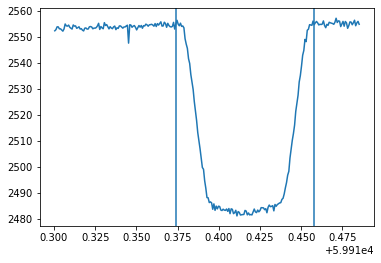

In [5]:
#initial inspection to set before/after time for normalisation, and T0
if 1:
    plt.plot(data.spec[1]['TIME'][:,1000],data.spec[1]['FLUX'][:,1000:1100].mean(axis=1))
    tbefore=59910.374
    tafter=59910.458
    plt.axvline(tbefore)
    plt.axvline(tafter)
    print('T0 (est.):',(tbefore+tafter)/2)
    

In [6]:
#add time, missing here
#data.compute_time()

In [7]:
# -------------------------------------------------------------------------
# remove wavelengths corresponding to null flux
cprint('Removing null flux values')
data.remove_null_flux()

2023-06-20T12:17:26.414| Removing null flux values


In [8]:
#remove some spectral region
if 0:
    for order in data.orders:
        bad=np.in1d(np.arange(data.n_wav[order]), np.arange(837,852))
        for quantity in data.spec[order]:
            data.spec[order][quantity] = data.spec[order][quantity][:, ~bad]
        # update nwave
        data.n_wav[order] = data.spec[order]['WAVELENGTH'].shape[1]

In [9]:
# -------------------------------------------------------------------------
# apply normalization (normalize by mean out-of-transit)
# cprint('Normalizing by out-of-transit flux for each wavelength')
data.normalize_by_out_of_transit_flux(params)

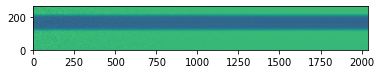

In [10]:
# plt.imshow(data.spec[1]['FLUX'],vmin=0.99,vmax=1.005,origin='lower')
plt.imshow(data.spec[1]['FLUX'],origin='lower')

In [11]:
#remove some temporal region
if 1:
    #remove first 10 integrations
    bad=np.in1d(np.arange(data.n_int), np.arange(0,10))
    for order in data.orders:
        for quantity in data.spec[order]:
            data.spec[order][quantity] = data.spec[order][quantity][~bad,:]
    # update n_int
    data.n_int = data.spec[data.orders[0]]['WAVELENGTH'].shape[0]

In [12]:
# -------------------------------------------------------------------------
# apply normalization (normalize by mean out-of-transit)
# cprint('Normalizing by out-of-transit flux for each wavelength')
data.normalize_by_out_of_transit_flux(params)

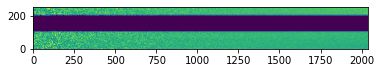

In [13]:
plt.imshow(data.spec[1]['FLUX'],vmin=0.99,vmax=1.005,origin='lower')

In [14]:
# -------------------------------------------------------------------------
# apply spectral binning
cprint('Applying spectral binning')
data.apply_spectral_binning(params)


# -------------------------------------------------------------------------
# apply normalization (normalize by mean out-of-transit)
# cprint('Normalizing by out-of-transit flux for each wavelength')
data.normalize_by_out_of_transit_flux(params)

# -------------------------------------------------------------------------
# remove any bins user wishes to remove
# cprint('Remove bins from order')
# data.remove_bins(params)



2023-06-20T12:17:30.269| Applying spectral binning


In [15]:
#adjust the errors...
#in white light, errors don't decrease as expected
#don't do in spec
if 0:
    for onum in params['ORDERS']:
        for bpass in range(data.spec[onum]['FLUX'].shape[1]):
            i,=((data.spec[onum]['TIME'][:,bpass]<params['TNORM']['before'])|
                (data.spec[onum]['TIME'][:,bpass]>params['TNORM']['after'])).nonzero()
            ftmp=data.spec[onum]['FLUX'][i,bpass]
            sig=np.median(np.abs(ftmp-np.median(ftmp)))/0.6745
            data.spec[onum]['FLUX_ERROR'][:,bpass]=sig

In [16]:
# -------------------------------------------------------------------------
# create the photospectra dictionary (data.phot)
data.photospectra()

In [17]:
#make sure there are no NaN left
print('NaN in data:',np.isnan(data.spec[1]['FLUX']).sum())

NaN in data: 0


2023-06-20T12:17:32.805| PLOTTING: plot_flux


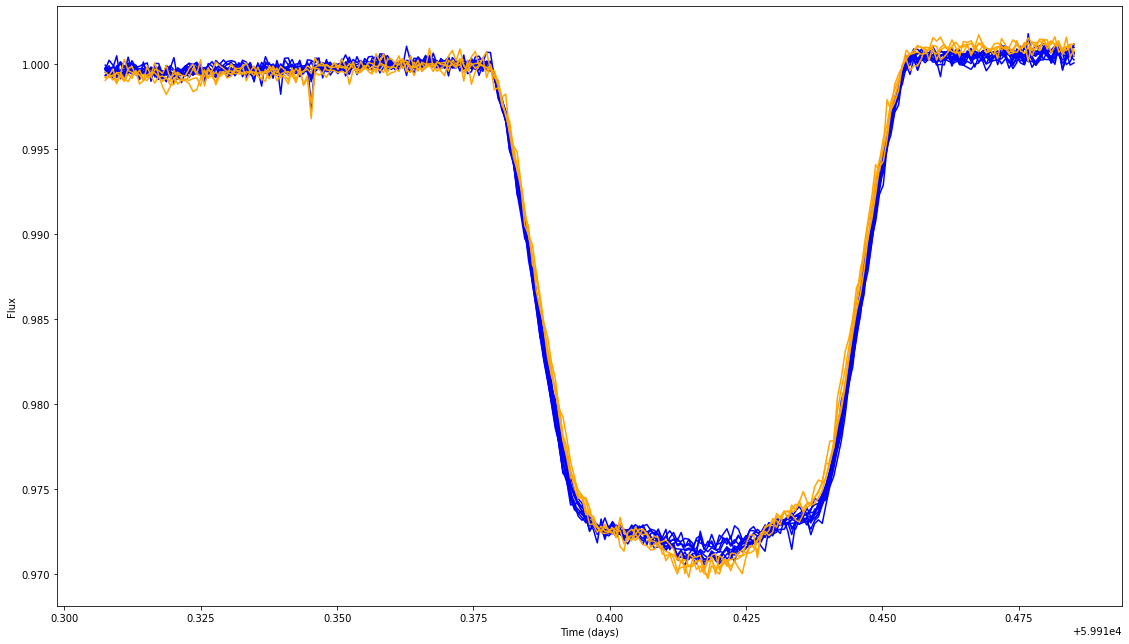

In [18]:
# Show a plot of the data. Each colour is a different wavelength.
plot.plot_flux(params, data)

In [19]:
# import importlib
# importlib.reload(mcmc)

In [20]:
# -------------------------------------------------------------------------
# Step 3: set up the parameters
#         All data manipulation + parameter changes should be done
#         before this point
# -------------------------------------------------------------------------
# get starting parameters for transit fit
tfit = mcmc.setup_params_mcmc(params, data)

In [21]:
############################
#DEFINE TRENDS VECTORS
#must match number of trends specified in parameter file
############################
tfit.trends_vec[0] = tfit.time-np.median(tfit.time) #linear term with time

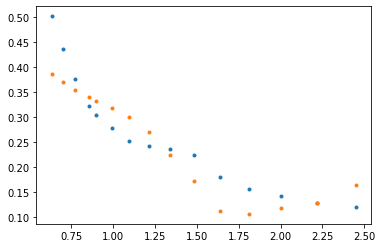

In [23]:
#################################################
#ASSIGN CHROMATIC FIXED VALUES HERE, if desired
#################################################

if 1:
    from exotic_ld import StellarLimbDarkening
    ld_data_path="/home/dlafre/projects/def-dlafre/exotic_ld_data/"
    M_H=0.0
    Teff=5000
    logg=4.5
    sld = StellarLimbDarkening(M_H=M_H, Teff=Teff, logg=logg,
                               ld_model="mps1", ld_data_path=ld_data_path,
                               interpolate_type="nearest",verbose=False)

    wvs = np.linspace(6000., 30000., 1000)
    throughput = np.full_like(wvs,1)

    iq1,=(tfit.pnames=='q1').nonzero()
    iq2,=(tfit.pnames=='q2').nonzero()
    for i in range(tfit.flux.shape[0]):
        c1,c2 = sld.compute_quadratic_ld_coeffs(data.phot['BIN_LIMITS'][i]*10000,mode='custom',
                            custom_wavelengths=wvs,custom_throughput=throughput)
        q1=(c1+c2)**2 #kipping parametrization
        q2=0.5*c1/(c1 + c2) #kipping parametrization

        tfit.p0[iq1,i]=q1
        tfit.p0[iq2,i]=q2

    plt.plot(tfit.wavelength[:,0],tfit.p0[iq1,:].flatten(),'.')
    plt.plot(tfit.wavelength[:,0],tfit.p0[iq2,:].flatten(),'.')    

In [24]:
#########################################################
#ASSIGN CHROMATIC PRIORS OF FITTED PARAMETERS, if desired
#########################################################

if 0:
    from exotic_ld import StellarLimbDarkening
    ld_data_path="/home/dlafre/projects/def-dlafre/exotic_ld_data/"
    M_H=0.1
    Teff=6600
    logg=4.25
    sld = StellarLimbDarkening(M_H=M_H, Teff=Teff, logg=logg,
                               ld_model="mps1", ld_data_path=ld_data_path,
                               interpolate_type="nearest",verbose=False)

    wvs = np.linspace(6000., 30000., 1000)
    throughput = np.full_like(wvs,1)

    iq1,=(tfit.xnames=='q1').nonzero()
    iq2,=(tfit.xnames=='q2').nonzero()
    for i in range(tfit.flux.shape[0]):
        c1,c2 = sld.compute_quadratic_ld_coeffs(data.phot['BIN_LIMITS'][i]*10000,mode='custom',
                            custom_wavelengths=wvs,custom_throughput=throughput)
        q1=(c1+c2)**2 #kipping parametrization
        q2=0.5*c1/(c1 + c2) #kipping parametrization

        tfit.x0[iq1[i]]=q1
        tfit.xpriors[iq1[i]][1]['mu']=q1
        tfit.xpriors[iq1[i]][1]['sigma']=0.1

        tfit.x0[iq2[i]]=q2
        tfit.xpriors[iq2[i]][1]['mu']=q2
        tfit.xpriors[iq2[i]][1]['sigma']=0.1
        
    tfit.update_p0_from_x0()
    plt.plot(tfit.wavelength[:,0],tfit.x0[iq1],'.')
    plt.plot(tfit.wavelength[:,0],tfit.x0[iq2],'.')

In [25]:
#######################################################
#Build the limb darkening coeff interpolation functions
#######################################################

#this is for runs sampling Teff and llog rather than the LD coeffs directly
if 0:
    from exotic_ld import StellarLimbDarkening
    ld_data_path="/home/dlafre/projects/def-dlafre/exotic_ld_data/"

    #first set the limits and sampling points of the grid in Teff and logg
    #here we assumes priors are truncated gaussians
    teff_min=np.floor(params['TEFF'].prior['vmin']/100)*100
    teff_max=np.ceil(params['TEFF'].prior['vmax']/100)*100
    teff_vec=np.arange(teff_min,teff_max+1,100) #mps1 samples are spaced by 100
    logg_vec=np.array([3.0,3.5,4.0,4.2,4.3,4.4,4.5,4.6,4.7,5.0]) #the sample points in mps1
    i1=(logg_vec<=params['LOGG'].prior['vmin']).nonzero()[0].max()
    i2=(logg_vec>=params['LOGG'].prior['vmax']).nonzero()[0].min()
    logg_vec=logg_vec[i1:i2+1]

    M_H=params['METAL'].value

    wvs = np.linspace(6000., 30000., 1000)
    throughput = np.full_like(wvs,1)

    q1=np.empty((teff_vec.size,logg_vec.size,tfit.flux.shape[0]))
    q2=np.empty_like(q1)
    for i in range(teff_vec.size):
        for j in range(logg_vec.size):
            teff=teff_vec[i]
            logg=logg_vec[j]
    #         print(teff,logg,M_H)
            sld = StellarLimbDarkening(M_H=M_H, Teff=teff, logg=logg,
                               ld_model="mps1", ld_data_path=ld_data_path,
                               interpolate_type="nearest",verbose=False)

            for k in range(tfit.flux.shape[0]):
                c1,c2 = sld.compute_quadratic_ld_coeffs(data.phot['BIN_LIMITS'][k]*10000,
                                mode='custom',
                                custom_wavelengths=wvs,custom_throughput=throughput)
                q1[i,j,k]=(c1+c2)**2 #kipping parametrization
                q2[i,j,k]=0.5*c1/(c1 + c2) #kipping parametrization

    #now build the interpolation functions
    from scipy.interpolate import RegularGridInterpolator

    for k in range(tfit.flux.shape[0]):
        q1f=RegularGridInterpolator((teff_vec, logg_vec), q1[:,:,k])
        q2f=RegularGridInterpolator((teff_vec, logg_vec), q2[:,:,k])
        tfit.ld_func.append((q1f,q2f))
        
    #check that interpolation functions work
    teff=params['TEFF'].value
    logg=params['LOGG'].value
    q1tmp=np.empty(tfit.flux.shape[0])
    q2tmp=np.empty(tfit.flux.shape[0])
    for k in range(tfit.flux.shape[0]):
        q1tmp[k]=tfit.ld_func[k][0]((teff,logg))
        q2tmp[k]=tfit.ld_func[k][1]((teff,logg))

    plt.plot(data.phot['WAVELENGTH'][:,0],q1tmp,'.')
    plt.plot(data.phot['WAVELENGTH'][:,0],q2tmp,'.')

In [26]:
#check initial values of the parameters
bpass=5
for i,n in enumerate(tfit.pnames):
    print(n,tfit.p0[i,bpass])

ZPT 0.0
q1 0.22290175230001613
q2 0.1707364241626183
SX1 -0.26
SY1 0.7
SR1 0.08
SC1 0.8
SX2 0.37
SY2 0.43
SR2 0.07
SC2 0.7
EP1 59910.41639
PE1 1.74978119
BB1 0.6
RD1 0.1658
SMA1 7.22
EC1 0.0
ES1 0.0
DSC 1.0
TC1 0.007


2023-06-20T12:18:27.892| PLOTTING: plot_transit_fit


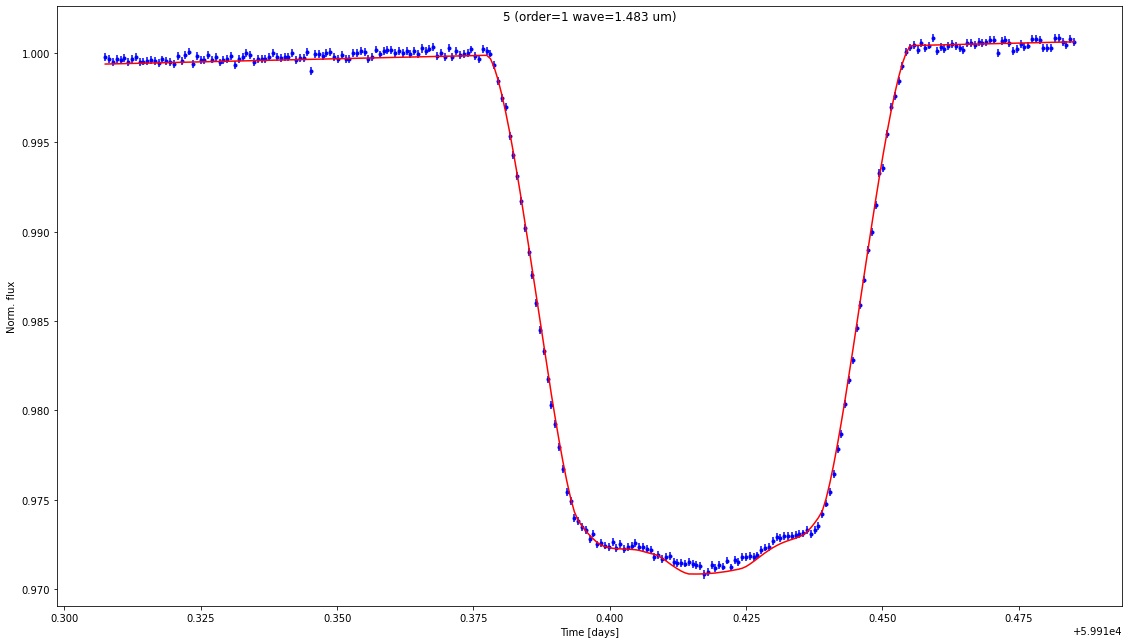

In [27]:
# Check that all is good
plot.plot_transit_fit(tfit, bandpass=5)

In [28]:
#check that the priors are fine
print(mcmc.lnpriors(tfit))

1.0


In [29]:
#check that the lnprob works fine
print(mcmc.lnprob(tfit))

25735.41834996885


In [30]:
print("Number of parameters to fit:",tfit.x0.shape[0])

Number of parameters to fit: 99


In [31]:
#if everything is ok, dump the tfit object to file
tfit.dump()

Dumped TransitFit object to file: /home/dlafre/projects/def-dlafre/dlafre/tfit/outputs/wasp-52b_fixed_ld_mft_tfit.pickle


In [ ]:
stop

In [ ]:
corscale = mcmc.beta_rescale_nwalker(tfit, mcmc.mhg_mcmc, mcmc.lnprob)

In [ ]:
tfit.ac

In [ ]:
corscale

In [ ]:
tfit.x0.shape

In [ ]:
import pympler

In [ ]:
from pympler import asizeof

In [ ]:
asizeof.asizeof(None)